##FDDB Dataset 다운로드

In [0]:
!mkdir data

In [7]:
!wget "https://drive.google.com/uc?authuser=0&id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download" -O fddb.zip

--2019-04-10 06:26:58--  https://drive.google.com/uc?authuser=0&id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download
Resolving drive.google.com (drive.google.com)... 74.125.129.101, 74.125.129.138, 74.125.129.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.129.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/uc?id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download [following]
--2019-04-10 06:26:58--  https://drive.google.com/uc?id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7g60ravddpj5jh4i6pesaeqo05vfsek6/1554876000000/15098959873704847008/*/1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8?e=download [following]
--2019-04-10 06:27:10--  https://doc-0o-bo-docs.googleusercontent.com/docs/securesc

In [8]:
!ls

data  fddb.zip	sample_data


In [9]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
!unzip -q fddb.zip

In [0]:
!mv face data/FDDB

In [12]:
!ls data/FDDB

test  train


In [13]:
!ls data/FDDB/train

anchors.json  annotations  classes.json  images


## Data Loader for Detection Model


In [0]:
import os
import numpy as np
import cv2
from cv2 import imread, resize, imwrite
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import glob
import json

In [0]:
IM_EXTENSIONS = ['png', 'jpg', 'bmp']

def load_json(json_path):
    """
    Load json file
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def get_best_anchor(anchors, box_wh):
    """
    Select the best anchor with highest IOU
    """
    box_wh = np.array(box_wh)
    best_iou = 0
    best_anchor = 0
    for k, anchor in enumerate(anchors):
        intersect_wh = np.maximum(np.minimum(box_wh, anchor), 0.0)
        intersect_area = intersect_wh[0] * intersect_wh[1]
        box_area = box_wh[0] * box_wh[1]
        anchor_area = anchor[0] * anchor[1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        if iou > best_iou:
            best_iou = iou
            best_anchor = k
    return best_anchor

In [0]:
def read_data(data_dir, image_size, pixels_per_grid=32, no_label=False, ratio=1, order='HWC'):
    """
    Load the data and preprocessing for YOLO detector
    :param data_dir: str, path to the directory to read. 
                     It should include class_map, anchors, annotations
    :image_size: tuple, image size for resizing images
    :pixels_per_gird: int, the actual size of a grid
    :no_label: bool, whetehr to load labels
    :return: X_set: np.ndarray, shape: (N, H, W, C).
             y_set: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes).
    """
    im_dir = os.path.join(data_dir, 'images')
    class_map_path = os.path.join(data_dir, 'classes.json')
    anchors_path = os.path.join(data_dir, 'anchors.json')
    class_map = load_json(class_map_path)
    anchors = load_json(anchors_path)
    num_classes = len(class_map)
    grid_h, grid_w = [image_size[i] // pixels_per_grid for i in range(2)]
    im_paths = []
    for ext in IM_EXTENSIONS:
        im_paths.extend(glob.glob(os.path.join(im_dir, '*.{}'.format(ext))))
    if ratio != 1:
      num_img = int(len(im_paths)*ratio)
      im_paths = im_paths[:num_img]
    anno_dir = os.path.join(data_dir, 'annotations')
    images = []
    labels = []

    for im_path in im_paths:
        # load image and resize image
        im = imread(im_path)
        im = np.array(im, dtype=np.float32)
        im_origina_sizes = im.shape[:2]
        im = resize(im, (image_size[1], image_size[0]))
        if len(im.shape) == 2:
            im = np.expand_dims(im, 2)
            im = np.concatenate([im, im, im], -1)
        images.append(im)

        if no_label:
            labels.append(0)
            continue
        # load bboxes and reshape for yolo model
        name = os.path.splitext(os.path.basename(im_path))[0]
        anno_path = os.path.join(anno_dir, '{}.anno'.format(name))
        anno = load_json(anno_path)
        label = np.zeros((grid_h, grid_w, len(anchors), 5 + num_classes))
        for c_idx, c_name in class_map.items():
            if c_name not in anno:
                continue
            for x_min, y_min, x_max, y_max in anno[c_name]:
                oh, ow = im_origina_sizes
                # normalize object coordinates and clip the values
                x_min, y_min, x_max, y_max = x_min / ow, y_min / oh, x_max / ow, y_max / oh
                x_min, y_min, x_max, y_max = np.clip([x_min, y_min, x_max, y_max], 0, 1)
                # assign the values to the best anchor
                anchor_boxes = np.array(anchors) / np.array([ow, oh])
                best_anchor = get_best_anchor(
                    anchor_boxes, [x_max - x_min, y_max - y_min])
                cx = int(np.floor(0.5 * (x_min + x_max) * grid_w))
                cy = int(np.floor(0.5 * (y_min + y_max) * grid_h))
                label[cy, cx, best_anchor, 0:4] = [x_min, y_min, x_max, y_max]
                label[cy, cx, best_anchor, 4] = 1.0
                label[cy, cx, best_anchor, 5 + int(c_idx)] = 1.0
        labels.append(label)

    X_set = np.array(images, dtype=np.float32)
    y_set = np.array(labels, dtype=np.float32)
    if order == 'CHW':
      X_set = np.transpose(X_set, [0, 3, 1, 2])

    return X_set, y_set

In [0]:
class DataSet(object):

    def __init__(self, images, labels=None):
        """
        Construct a new DataSet object.
        :param images: np.ndarray, shape: (N, H, W, C)
        :param labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes).
        """
        if labels is not None:
            assert images.shape[0] == labels.shape[0],\
                ('Number of examples mismatch, between images and labels')
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels  # NOTE: this can be None, if not given.
        # image/label indices(can be permuted)
        self._indices = np.arange(self._num_examples, dtype=np.uint)
        self._reset()

    def _reset(self):
        """Reset some variables."""
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    def sample_batch(self, batch_size, shuffle=True):
        """
        Return sample examples from this dataset.
        :param batch_size: int, size of a sample batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :return: batch_images: np.ndarray, shape: (N, H, W, C)
                 batch_labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes)
        """

        if shuffle:
            indices = np.random.choice(self._num_examples, batch_size)
        else:
            indices = np.arange(batch_size)
        batch_images = self._images[indices]
        if self._labels is not None:
            batch_labels = self._labels[indices]
        else:
            batch_labels = None
        return batch_images, batch_labels

    def next_batch(self, batch_size, shuffle=True):
        """
        Return the next 'batch_size' examples from this dataset.
        :param batch_size: int, size of a single batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :return: batch_images: np.ndarray, shape: (N, H, W, C)
                 batch_labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes)
        """

        start_index = self._index_in_epoch

        # Shuffle the dataset, for the first epoch
        if self._epochs_completed == 0 and start_index == 0 and shuffle:
            np.random.shuffle(self._indices)

        # Go to the next epoch, if current index goes beyond the total number
        # of examples
        if start_index + batch_size > self._num_examples:
            # Increment the number of epochs completed
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start_index
            indices_rest_part = self._indices[start_index:self._num_examples]

            # Shuffle the dataset, after finishing a single epoch
            if shuffle:
                np.random.shuffle(self._indices)

            # Start the next epoch
            start_index = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end_index = self._index_in_epoch
            indices_new_part = self._indices[start_index:end_index]

            images_rest_part = self._images[indices_rest_part]
            images_new_part = self._images[indices_new_part]
            batch_images = np.concatenate(
                (images_rest_part, images_new_part), axis=0)
            if self._labels is not None:
                labels_rest_part = self._labels[indices_rest_part]
                labels_new_part = self._labels[indices_new_part]
                batch_labels = np.concatenate(
                    (labels_rest_part, labels_new_part), axis=0)
            else:
                batch_labels = None
        else:
            self._index_in_epoch += batch_size
            end_index = self._index_in_epoch
            indices = self._indices[start_index:end_index]
            batch_images = self._images[indices]
            if self._labels is not None:
                batch_labels = self._labels[indices]
            else:
                batch_labels = None

        return batch_images, batch_labels

In [0]:
# set paths
root_dir = os.path.join('data/FDDB/') #FIXME
trainval_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
anchors = load_json(os.path.join(trainval_dir, 'anchors.json'))
class_map = load_json(os.path.join(trainval_dir, 'classes.json'))

# set hyperparameters for data
IM_SIZE = (416, 416)
NUM_CLASSES = 1
VALID_RATIO = 0.1

In [0]:
X_trainval, y_trainval = read_data(trainval_dir, IM_SIZE, ratio=0.5, order='CHW')
trainval_size = X_trainval.shape[0]
val_size = int(trainval_size * VALID_RATIO)
val_set = DataSet(X_trainval[:val_size], y_trainval[:val_size])
train_set = DataSet(X_trainval[val_size:], y_trainval[val_size:])

In [0]:

X_test, y_test = read_data(test_dir, IM_SIZE, order='CHW')
test_set = DataSet(X_test, y_test)

## Construct Network & Build Loss

In [0]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [9]:
device_name = torch.cuda.current_device()
print('Device name: {}'.format(device_name))

assert device_name == 0

Device name: 0


In [0]:
def conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                     padding=padding, bias=bias)

def max_pool(kernel_size, stride, padding=0):
    return nn.MaxPool2d(kernel_size, stride=stride, padding=padding)
  
class ConvBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, act=nn.LeakyReLU()):
        super().__init__()

        self.conv = conv2d(in_channels, out_channels, kernel_size, stride=stride,
                           padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = act

    def forward(self, x):
        if self.act is None:
            return self.bn(self.conv(x))
        else:
            return self.act(self.bn(self.conv(x)))
          
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

In [0]:
input_shape = [3] + list(IM_SIZE)
grid_size = [x // 32 for x in input_shape[1:]]
num_classes = NUM_CLASSES
num_anchors = len(anchors)

In [0]:
class Yolov2(DetectNet):

    def __init__(self, input_shape, num_classes, anchors, **kwargs):

        super(Yolov2, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = len(anchors)
        self.d = self._prepare_module()
        self.is_cuda = torch.cuda.is_available()

        grid_size = [x // 32 for x in input_shape[1:]]
        grid_h, grid_w = grid_size
        grid_wh = torch.tensor([grid_w, grid_h]).view(1, 1, 2, 1, 1).float()
        cxcy = np.transpose([np.tile(np.arange(grid_w), grid_h),
                             np.repeat(np.arange(grid_h), grid_h)])
        cxcy = np.transpose(cxcy, [1, 0])
        cxcy = np.reshape(cxcy, (1, 1, 2, grid_h, grid_w))
        cxcy = torch.tensor(cxcy).float()

        anchors = torch.tensor(anchors).float()
        pwph = anchors.view(1, len(anchors), 2, 1, 1) / 32

        self.cxcy = Variable(cxcy, requires_grad=False)
        self.pwph = Variable(pwph, requires_grad=False)
        self.grid_wh = Variable(grid_wh, requires_grad=False)
        if self.is_cuda:
            self.cuda()
            self.cxcy = self.cxcy.cuda()
            self.pwph = self.pwph.cuda()
            self.grid_wh = self.grid_wh.cuda()

    def _prepare_module(self):

        d = dict()

        #conv1 - batch_norm1 - leaky_relu1 - pool1
        d['conv1'] = ConvBnAct(3, 32, 3, stride=1, padding=1)
        d['pool1'] = max_pool(2, 2)

        #conv2 - batch_norm2 - leaky_relu2 - pool2
        d['conv2'] = ConvBnAct(32, 64, 3, stride=1, padding=1)
        d['pool2'] = max_pool(2, 2)

        #conv3 - batch_norm3 - leaky_relu3
        d['conv3'] = ConvBnAct(64, 128, 3, stride=1, padding=1)

        #conv4 - batch_norm4 - leaky_relu4
        d['conv4'] = ConvBnAct(128, 64, 1, stride=1, padding=0)

        #conv5 - batch_norm5 - leaky_relu5 - pool5
        d['conv5'] = ConvBnAct(64, 128, 3, stride=1, padding=1)
        d['pool5'] = max_pool(2, 2)

        #conv6 - batch_norm6 - leaky_relu6
        d['conv6'] = ConvBnAct(128, 256, 3, stride=1, padding=1)

        #conv7 - batch_norm7 - leaky_relu7
        d['conv7'] = ConvBnAct(256, 128, 1, stride=1, padding=0)

        #conv8 - batch_norm8 - leaky_relu8 - pool8
        d['conv8'] = ConvBnAct(128, 256, 3, stride=1, padding=1)
        d['pool8'] = max_pool(2, 2)

        #conv9 - batch_norm9 - leaky_relu9
        d['conv9'] = ConvBnAct(256, 512, 3, stride=1, padding=1)

        #conv10 - batch_norm10 - leaky_relu10
        d['conv10'] = ConvBnAct(512, 256, 1, stride=1, padding=0)

        #conv11 - batch_norm11 - leaky_relu11
        d['conv11'] = ConvBnAct(256, 512, 3, stride=1, padding=1)

        #conv12 - batch_norm12 - leaky_relu12
        d['conv12'] = ConvBnAct(512, 256, 1, stride=1, padding=0)

        #conv13 - batch_norm13 - leaky_relu13 - pool13
        d['conv13'] = ConvBnAct(256, 512, 3, stride=1, padding=1)
        d['pool13'] = max_pool(2, 2)

        #conv14 - batch_norm14 - leaky_relu14
        d['conv14'] = ConvBnAct(512, 1024, 3, stride=1, padding=1)

        #conv15 - batch_norm15 - leaky_relu15
        d['conv15'] = ConvBnAct(1024, 512, 1, stride=1, padding=0)

        #conv16 - batch_norm16 - leaky_relu16
        d['conv16'] = ConvBnAct(512, 1024, 3, stride=1, padding=1)

        #conv17 - batch_norm16 - leaky_relu17
        d['conv17'] = ConvBnAct(1024, 512, 1, stride=1, padding=0)

        #conv18 - batch_norm18 - leaky_relu18
        d['conv18'] = ConvBnAct(512, 1024, 3, stride=1, padding=1)

        #conv19 - batch_norm19 - leaky_relu19
        d['conv19'] = ConvBnAct(1024, 1024, 3, stride=1, padding=1)

        # Detection Layer
        #conv20 - batch_norm20 - leaky_relu20
        d['conv20'] = ConvBnAct(1024, 1024, 3, stride=1, padding=1)

        # concatenate layer20 and layer 13 using space to depth
        d['skip_connection'] = nn.Sequential(
            ConvBnAct(512, 64, 1, stride=1, padding=0), SpaceToDepth(2))
        d['conv21'] = ConvBnAct(1024, 1024, 3, stride=1, padding=1)

        #conv22 - batch_norm22 - leaky_relu22
        d['conv22'] = ConvBnAct(1280, 1024, 3, stride=1, padding=1)

        output_channel = self.num_anchors * (5 + self.num_classes)
        d['logits'] = conv2d(1024, output_channel, 1,
                             stride=1, padding=0, bias=True)

        self.module = nn.ModuleList()
        for i in d.values():
            self.module.append(i)
        return d

    def forward(self, x):

        d = self.d
        out = x
        for name in d:
            if name == 'conv13':
                out = d[name](out)
                skip = out
            elif name == 'skip_connection':
                skip = d[name](skip)
            elif name == 'conv21':
                out = torch.cat((d[name](out), skip), dim=1)
            else:
                out = d[name](out)
        out = out.view(-1, self.num_anchors, (5 + self.num_classes),
                       out.size()[-2], out.size()[-1])

        return out

    def _decode_output(self, x):
        num_classes = self.num_classes
        cxcy = self.cxcy
        pwph = self.pwph
        pred = self.forward(x)

        txty, twth = pred[:, :,  0:2, :, :], pred[:, :, 2:4, :, :]
        confidence = torch.sigmoid(pred[:, :, 4:5, :, :])
        class_probs = F.softmax(pred[:, :, 5:, :, :], dim=2)\
            if num_classes > 1 else torch.sigmoid(pred[:, :, 5:, :, :])
        bxby = torch.sigmoid(txty) + cxcy
        bwbh = torch.exp(twth) * pwph

        return bxby, bwbh, confidence, class_probs

    def output(self, x):
        grid_wh = self.grid_wh
        bxby, bwbh, confidence, class_probs = self._decode_output(x)
        # calculating for prediction
        nxny, nwnh = bxby / grid_wh, bwbh / grid_wh
        nx1ny1, nx2ny2 = nxny - 0.5 * nwnh, nxny + 0.5 * nwnh
        pred_y = torch.cat((nx1ny1, nx2ny2, confidence, class_probs), dim=2)
        pred_y = pred_y.permute(0, 3, 4, 1, 2)
        return pred_y

    def yoloLoss(self, x, y):
        loss_weights = [5, 5, 5, 0.5, 1.0]  # FIXME
        grid_wh = self.grid_wh
        y = y.permute(0, 3, 4, 1, 2)

        bxby, bwbh, confidence, class_probs = self._decode_output(x)

        gt_bxby = 0.5 * (y[:, :, 0:2, :, :] + y[:, :, 2:4, :, :]) * grid_wh
        gt_bwbh = (y[:, :, 2:4, :, :] - y[:, :, 0:2, :, :]) * grid_wh

        resp_mask = y[:, :, 4:5, :, :]
        no_resp_mask = 1.0 - resp_mask
        gt_confidence = resp_mask
        gt_class_probs = y[:, :, 5:, :, :]
        loss_bxby = loss_weights[0] * resp_mask * \
            torch.pow((gt_bxby - bxby), 2)
        loss_bwbh = loss_weights[1] * resp_mask * \
            torch.pow((gt_bwbh.sqrt() - bwbh.sqrt()), 2)
        loss_resp_conf = loss_weights[2] * resp_mask * \
            torch.pow((gt_confidence - confidence), 2)
        loss_no_resp_conf = loss_weights[
            3] * no_resp_mask * torch.pow((gt_confidence - confidence), 2)
        loss_class_probs = loss_weights[
            4] * resp_mask * torch.pow((gt_class_probs - class_probs), 2)

        merged_loss = torch.cat((
                                loss_bxby,
                                loss_bwbh,
                                loss_resp_conf,
                                loss_no_resp_conf,
                                loss_class_probs
                                ),
                                dim=2)
        total_loss = torch.sum(merged_loss, dim=2)
        total_loss = torch.mean(merged_loss)
        return total_loss

## Training Session

In [0]:
def nms(boxes, conf_thres=0.2, iou_thres=0.5):
    x1 = boxes[..., 0]
    y1 = boxes[..., 1]
    x2 = boxes[..., 2]
    y2 = boxes[..., 3]
    areas = (x2 - x1) * (y2 - y1)
    scores = boxes[..., 4]

    keep = []
    order = scores.argsort()[::-1]

    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thres)[0]
        order = order[inds + 1]

    nms_box = []
    for idx in range(len(boxes)):
        if idx in keep and boxes[idx, 4] > conf_thres:
            nms_box.append(boxes[idx])
        else:
            nms_box.append(np.zeros(boxes.shape[-1]))
    boxes = np.array(nms_box)
    return boxes

def convert_boxes(input_y):
    is_batch = len(input_y.shape) == 5
    if not is_batch:
        input_y = np.expand_dims(input_y, 0)
    boxes = np.reshape(input_y, (input_y.shape[0], -1, input_y.shape[-1]))
    if is_batch:
        return np.array(boxes)
    else:
        return boxes[0]

def predict_nms_boxes(input_y, conf_thres=0.2, iou_thres=0.5):
    is_batch = len(input_y.shape) == 5
    if not is_batch:
        input_y = np.expand_dims(input_y, 0)
    boxes = np.reshape(input_y, (input_y.shape[0], -1, input_y.shape[-1]))
    nms_boxes = []
    for box in boxes:
        nms_box = nms(box, conf_thres, iou_thres)
        nms_boxes.append(nms_box)
    if is_batch:
        return np.array(nms_boxes)
    else:
        return nms_boxes[0]

def cal_recall(gt_bboxes, bboxes, iou_thres=0.5):
    p = 0
    tp = 0
    for idx, (gt, bbox) in enumerate(zip(gt_bboxes, bboxes)):
        gt = gt[np.nonzero(np.any(gt > 0, axis=1))]
        bbox = bbox[np.nonzero(np.any(bbox > 0, axis=1))]
        p += len(gt)
        if bbox.size == 0:
            continue
        iou = _cal_overlap(gt, bbox)
        predicted_class = np.argmax(bbox[...,5:], axis=-1)
        for g, area in zip(gt, iou):
            gt_c = np.argmax(g[5:])
            idx = np.argmax(area)
            if np.max(area) > iou_thres and predicted_class[idx] == gt_c:
                tp += 1
    return tp / p

def _cal_overlap(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - \
        np.maximum(np.expand_dims(a[:, 0], axis=1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - \
        np.maximum(np.expand_dims(a[:, 1], axis=1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)
    intersection = iw * ih

    ua = np.expand_dims((a[:, 2] - a[:, 0]) *
                        (a[:, 3] - a[:, 1]), axis=1) + area - intersection

    ua = np.maximum(ua, np.finfo(float).eps)

    return intersection / ua


In [0]:
def score(y_true, y_pred, **kwargs):
    """Compute Recall for a given predicted bboxes"""
    nms_flag = kwargs.pop('nms_flag', True)
    if nms_flag:
        bboxes = predict_nms_boxes(y_pred)
    else:
        bboxes = convert_boxes(y_pred)
    gt_bboxes = convert_boxes(y_true)
    score = cal_recall(gt_bboxes, bboxes)
    return score

def predict(model, dataset, **kwargs):
    batch_size = kwargs.pop('batch_size', 16)
    pred_size = dataset.num_examples
    num_steps = pred_size // batch_size
    flag = int(bool(pred_size % batch_size))
    # Start prediction loop
    _y_pred = []
    model.eval()
    for i in range(num_steps + flag):
        if i == num_steps and flag:
            _batch_size = pred_size - num_steps * batch_size
        else:
            _batch_size = batch_size
        X_true, _ = dataset.next_batch(_batch_size, shuffle=False)
        X_true = torch.tensor(X_true).cuda()
        # Compute predictions
        y_pred = model.output(X_true).cpu().detach().numpy()

        _y_pred.append(y_pred)
    _y_pred = np.concatenate(_y_pred, axis=0)
    return _y_pred

In [0]:
# Set hyperparameters for training
batch_size = 2
num_epochs = 5
learning_rate = 1e-5
eps = 1e-3
num_eval = 128

In [0]:
# Prepare model
model = Yolov2(input_shape, num_classes, anchors)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.cuda()

train_size = train_set.num_examples
num_steps_per_epoch = train_size // batch_size
num_steps = num_epochs * num_steps_per_epoch

In [19]:
curr_epoch = 1
best_score = 0
curr_score = 0
# Start training loop

for i in range(num_steps):
    X_true, y_true = train_set.next_batch(batch_size, shuffle=True)
    if not model.training:
      model.train()
      
    opt.zero_grad()
    X, y = torch.tensor(X_true).cuda(), torch.tensor(y_true).cuda()
    loss = model.yoloLoss(X, y)
    y_pred = model.output(X).cpu().detach().numpy()
    loss.backward()
    opt.step()
    
    if (i+1) % num_eval == 0:
        step_score = score(y_true, y_pred)
        eval_y_pred = predict(model, val_set)
        eval_score = score(val_set.labels, eval_y_pred)
        print('[epoch {}]\tloss: {:.6f} |Train score: {:.6f} |Eval score: {:.6f}'
      .format(curr_epoch, loss, step_score, eval_score))
        curr_score = eval_score

    if curr_score > best_score + eps:
        best_score = curr_score
        torch.save({'model_state_dict': model.state_dict()}, './yolov2.pth')
        
    if (i+1) % num_steps_per_epoch == 0:
        curr_epoch += 1

[epoch 1]	loss: 0.010531 |Train score: 1.000000 |Eval score: 0.799145


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal


[epoch 1]	loss: 0.008023 |Train score: 1.000000 |Eval score: 0.786325
[epoch 1]	loss: 0.006631 |Train score: 1.000000 |Eval score: 0.747863
[epoch 1]	loss: 0.005755 |Train score: 1.000000 |Eval score: 0.811966
[epoch 2]	loss: 0.003753 |Train score: 1.000000 |Eval score: 0.743590
[epoch 2]	loss: 0.003809 |Train score: 0.750000 |Eval score: 0.705128
[epoch 2]	loss: 0.002853 |Train score: 1.000000 |Eval score: 0.645299
[epoch 2]	loss: 0.002911 |Train score: 0.666667 |Eval score: 0.611111
[epoch 2]	loss: 0.002170 |Train score: 1.000000 |Eval score: 0.555556
[epoch 3]	loss: 0.002013 |Train score: 1.000000 |Eval score: 0.470085
[epoch 3]	loss: 0.001798 |Train score: 0.500000 |Eval score: 0.594017
[epoch 3]	loss: 0.003100 |Train score: 0.600000 |Eval score: 0.470085
[epoch 3]	loss: 0.001854 |Train score: 1.000000 |Eval score: 0.555556
[epoch 4]	loss: 0.001799 |Train score: 0.666667 |Eval score: 0.564103
[epoch 4]	loss: 0.001156 |Train score: 1.000000 |Eval score: 0.581197
[epoch 4]	loss: 0.00

## Test image and draw bboxes

In [0]:
COLORS = [(100, 72, 247),
 (232, 237, 157),
 (45, 241, 42),
 (72, 251, 220),
 (115, 61, 201),
 (38, 253, 214),
 (233, 113, 18),
 (201, 141, 151),
 (57, 199, 175),
 (155, 90, 108),
 (130, 223, 66),
 (40, 211, 140)]

def draw_pred_boxes(image, pred_boxes, class_map, text=True, score=False, order='HWC'):
    if order == 'CHW':
        image = np.transpose(image, [1, 2, 0])
    im_h, im_w = image.shape[:2]
    output = image.copy()
    
    for box in pred_boxes:
        overlay = output.copy()

        class_idx = np.argmax(box[5:])
        color = COLORS[class_idx]
        line_width, alpha = (2, 0.8)
        x_min, x_max = [int(x * im_w) for x in [box[0], box[2]]]
        y_min, y_max = [int(x * im_h) for x in [box[1], box[3]]]
        cv2.rectangle(overlay, (x_min, y_min),
                      (x_max, y_max), color, line_width)
        output = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)

        if text:
            p_text = str(round(np.max(box[5:]), 3)) if score else class_map[str(class_idx)]
            y_offset = -6
            text_size = 0.6
            text_line_width = 1
            output = cv2.putText(output, p_text, (x_min + 4, y_min + y_offset),
                                 cv2.FONT_HERSHEY_DUPLEX, text_size, color, text_line_width)
    return output

In [0]:
# model.load_state_dict(torch.load('./yolov2.pth')['model_state_dict'])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./yolov2.ckpt


In [21]:
test_y_pred = predict(model, test_set)
test_score = score(test_set.labels, test_y_pred)

print('Test performance: {}'.format(test_score))

Test performance: 0.7131367292225201


In [0]:
r_idx = np.random.choice(test_set.num_examples, 1)
test_images = test_set.images[r_idx]
X = torch.tensor(test_images).cuda()
test_pred_y = model.output(X).cpu().detach().numpy()

In [0]:
bboxes = predict_nms_boxes(test_pred_y[0], conf_thres=0.5, iou_thres=0.5)
bboxes = bboxes[np.nonzero(np.any(bboxes > 0, axis=1))]
boxed_img = draw_pred_boxes(test_images[0], bboxes, class_map, order='CHW')

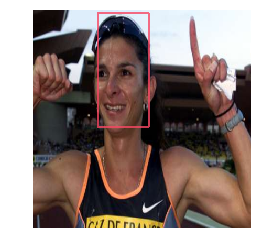

In [44]:
plt.axis("off")
imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB)/255)